# Adaptive time-stepper for ODEs
In this notebook, we show how to train a neural network to suggest optimal step sizes for Runge-Kutta methods. Consider the Lorenz system, i.e.
    $$ \frac{d}{dt} \begin{bmatrix} x_1 \\
            x_2 \\
            x_3
       \end{bmatrix} = \begin{bmatrix} \sigma (x_2 - x_1) \\
            x_1 (\rho - x_3) - x_2 \\
            x_1 x_2 - \beta x_3
       \end{bmatrix}$$
where $\sigma = 10$, $\beta = \tfrac{8}{3}$, and $\rho = 28$. We aim to integrate this ODE from initial conditions $t_0 = 0$, $x_0 = [10, 10, 10]^T$ until $t_1 = 10$. <br>
Let us first gather some information about the Lorenz system in the following variables:

In [1]:
import numpy as np

x0 = np.array([10, 10, 10])  # start point of integration
t0 = 0
t1 = 10
d = 3  # dimension of the ODE state space

step_sizes = [0.02, 0.022, 0.025, 0.029, 0.033, 0.039, 0.045, 0.052, 0.060, 0.070]  # the NN will choose from these step sizes
tol = 0.0001  # target integration error tolerance

For the integration itself we will use the 5th order Runge-Kutta method that is part of the Dormand-Prince Runge Kutta method (RKDP) (to which we will later compare). Thus, we define the following variables as a preparation for creating the NN:

In [2]:
from adaptive.integrator import RKDP
integrator = RKDP()

nodes_per_step = 6  # the RKDP method has 6 stages
dim_action = len(step_sizes)  # the dimension of the action space of the NN
memory = 0  # how many integration steps the predictor can look back

Furthermore, it is a good idea to scale the inputs of the NN to order $\approx 10^{-1}$. For this purpose we will use a scikit-learn `StandardScaler`. Note that the input dimension of the NN is given by `nodes_per_step * d + 1`. We will load a `StandardScaler` that has already been fitted to typical states for the Lorenz system. (To fit the scaler yourself, you can obtain the data by integrating the Lorenz system with randomly selected step sizes from `step_sizes`.)

In [3]:
from sklearn.preprocessing import StandardScaler
from joblib import load

scaler = load("adaptive/model_ode/lorenz/scaler.pkl")

Now we can initialize the NN. It is encapsuled by the `Predictor` object, which handles the interaction with the NN. The NN itself is created using tensorflow.

In [4]:
from adaptive.predictor import PredictorQODE
from adaptive.build_models import build_value_modelODE

predictor = PredictorQODE(step_sizes=step_sizes,
                          model=build_value_modelODE(dim_state=nodes_per_step * d + 1,
                                                     dim_action=dim_action,
                                                     memory=memory),
                          scaler=scaler)

During the training process we have to reward or penalize the NN for its time step choices. We choose a reward function of the following form: if the integration error is below the tolerance, reward the NN with a value scaling with the chosen time step, i.e., larger time steps yield larger rewards. If the integration error is larger than the tolerance, penalize the NN with a value scaling with the error, i.e., bigger errors yield more negative rewards. Here we use the `RewardLog10` reward function, which has a logarithmic scaling for both positive and negative rewards.

In [5]:
from adaptive.reward_functions import RewardLog10

step_size_range = (step_sizes[0], step_sizes[-1])  # range of expected step sizes
reward_range = (0.1, 2)  # range of positive rewards

reward_fun = RewardLog10(error_tol=tol, step_size_range=step_size_range, reward_range=reward_range)

# print some example rewards
errors = [0.1 * tol, 0.1 * tol, 0.1 * tol]
hs = [step_sizes[0], step_sizes[2], step_sizes[-1]]
print(f"positive rewards (error is smaller than tol={tol}):")
print("error, step size, reward")
for er, h in zip(errors, hs):
    print(er, h, round(reward_fun(er, h), 3))
print()
errors = [2 * tol, 10 * tol, 100 * tol]
hs = [step_sizes[0], step_sizes[0], step_sizes[0]]
print(f"negative rewards (error is larger than tol={tol}):")
print("error, step size, reward")
for er, h in zip(errors, hs):
    print(er, h, round(reward_fun(er, h), 3))

positive rewards (error is smaller than tol=0.0001):
error, step size, reward
1e-05 0.02 0.1
1e-05 0.025 0.438
1e-05 0.07 2.0

negative rewards (error is larger than tol=0.0001):
error, step size, reward
0.0002 0.02 -0.301
0.001 0.02 -1.0
0.01 0.02 -2.0


In order to train the NN, we will need to repeatedly integrate the given ODE. The `ODEEnv` class handles the integration process. The most important method is `ODEEnv.iterate`, which takes a step size as an argument, integrates the ODE with the provided step size for one step, and provides the next state as an output. Moreover, the `ODEEnv` class keeps track of the integration error and calculates the rewards for the step size choices.

In [6]:
from adaptive.environments import ODEEnv
from functions import LorenzSystem

env = ODEEnv(fun=LorenzSystem(), max_iterations=10000, initial_step_size=step_sizes[0],
             step_size_range=step_size_range, reward_fun=reward_fun,
             error_tol=tol, nodes_per_integ=nodes_per_step, memory=memory, x0=x0, t0=t0, max_dist=t1 - t0)

During the integration process we will store a few past states and desired NN outputs in an `Experience` object. If a certain number of experiences is stored or the integration is finished, we use the stored data (batch) to train the NN.

In [7]:
from adaptive.experience import ExperienceODE

experience = ExperienceODE(batch_size=64)

During training it is important that the NN explores sufficiently large parts of the action space in order to find the optimal step sizes for a given input. We will use the following function to randomly choose actions given the NN's output:

In [8]:
def choose_action(actions, eps, dim_action):
    """
    With probability 0.5*eps choose the action one above the favored action and with probability 0.5*eps the action
    below the favored.
    Otherwise choose the favored action.

    Parameters
    ----------
    actions : np.ndarray
    eps : float
    dim_action : int

    Returns
    -------
    int
    """
    favored = np.argmax(actions)
    rn = np.random.sample()

    if rn < 0.5 * eps:
        return min(favored + 1, dim_action - 1)
    if rn < eps:
        return max(favored - 1, 0)

    return favored

Finally, we train the NN. The following training loop illustrates the training process for a few episodes. However, we will load a fully trained NN afterwards, so that you do not have to do the training yourself.

In [9]:
import warnings
warnings.filterwarnings('ignore')

num_episodes = 3
gamma = 0  # discount factor for future rewards

for episode in range(3):
    state = env.reset(integrator=integrator)
    done = False
    eps = 0.5
    print('episode: {}'.format(episode))

    while not done:
        # get action from actor
        actions = predictor.get_actions(state)  # Q-value of each step size
        action = choose_action(actions, eps, dim_action)  # randomize step size
        step_size = predictor.action_to_stepsize(action)

        # execute action
        next_state, reward, done, _ = env.iterate(step_size, integrator)

        # find target values (more correct Q-values) for NN output
        action_next_state = predictor.get_actions(next_state)
        target = reward + gamma * np.max(action_next_state)
        target_actions = actions.squeeze()
        target_actions[action] = target
        # append target values to experience (batch)
        experience.append(state=state, target=target_actions)
        
        # train the NN
        if experience.is_full() or done:
            states, targets = experience.get_samples()
            predictor.train_on_batch(states, targets)
            experience.reset()

        state = next_state.copy()
    
    # uncomment if you want to train the NN yourself and save the weights:
    # predictor.model.save_weights('predictorODE')

episode: 0
episode: 1
episode: 2


In [10]:
# load the already trained NN
predictor.model = build_value_modelODE(dim_state=nodes_per_step * d + 1,
                                       dim_action=dim_action,
                                       memory=memory,
                                       filename='adaptive/model_ode/Lorenz/predictorODE')

Before we evaluate the performance of the time step predictor, let us plot the time stepping to see which time steps the predictor chooses.

reward: 536.8090842654722
nfev: 3096
mean error: 2.973715251050434e-05
min error, max error: 0.0, 9e-05
min stepsize: 0.02
max stepsize: 0.06


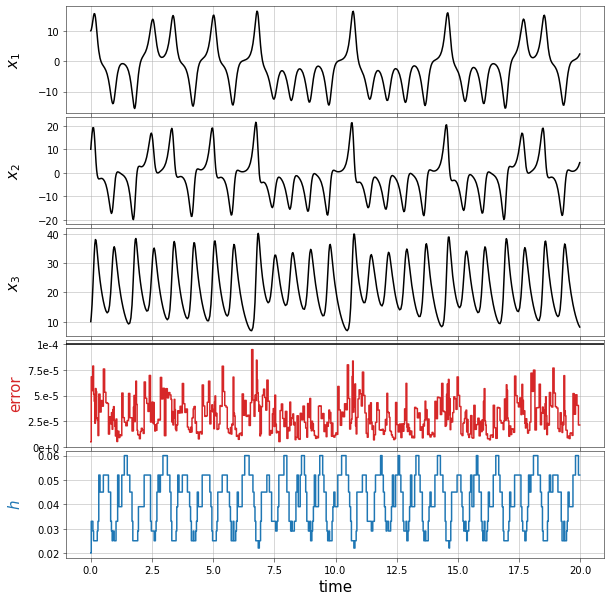

In [11]:
from adaptive.comparison_ode import integrate_env

# Integrate the environment from t0 to t1 using the specified predictor and integrator.
t0 = 0
t1 = 20
reward, num_evals = integrate_env(predictor, integrator, env, t0=t0, t1=t1)

print("reward: {}".format(reward))
print("nfev: {}".format(num_evals))
print("mean error: {}".format(np.mean(env.errors)))
print("min error, max error: {}, {}".format(*np.round((np.min(env.errors), np.max(env.errors)), 5)))
print("min stepsize: {}".format(np.min(env.deltas)))
print("max stepsize: {}".format(np.max(env.deltas)))

# plot the time-stepping
from adaptive.plots import plot_trajectory
fig, ax = plot_trajectory(x0=env.x0,
                          timesteps=env.timesteps,
                          nodes=env.nodes,
                          errors=env.errors,
                          deltas=env.deltas,
                          t_min=t0,
                          t_max=t1,
                          error_tolerance=env.error_tol,
                          figsize=(8, 8),
                          linewidth=1.5,
                          axislabelsize=15,
                          ticklabelsize=10
                         )

Now we compare the performance of our solver (RK5 with step size controlled by the NN) with the popular adaptive Runge Kutta method `RK45` (ode45).

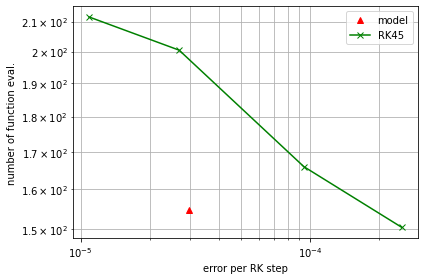

In [12]:
t1 = 20

# evaluate performance of model
reward, num_evals = integrate_env(predictor, integrator, env, t0=t0, t1=t1)
perf_nn = [np.mean(env.errors), num_evals / (t1 - t0)]

# evaluate performance of RK45
from scipy.integrate import solve_ivp  # this function uses RK45 per default

f = LorenzSystem()
perf_rk45 = []
tols = [5e-6, 1e-5, 2.5e-5, 5e-5]  # different tolerances for RK45

for tol in tols:
    f.reset()
    sol = solve_ivp(f, (t0, t1), x0, atol=tol, rtol=tol)
    x_predict = sol.y  # array of x (state) values of the RK45 solution
    t_predict = sol.t  # array of t (time) values of the RK45 solution
    # calculate step-wise absolute errors
    this_errors = []
    for idx in range(t_predict.shape[0] - 1):
        # true solution is approximated with very accurate solve_ivp (tolerance=1e-8)
        x_true = f.solve(t_predict[idx], x_predict[:, idx], t_predict[idx + 1]) 
        this_errors.append(np.linalg.norm(x_predict[:, idx + 1] - x_true))
    perf_rk45.append([np.mean(this_errors), sol.nfev / (t1 - t0)])
perf_rk45 = np.array(perf_rk45)

# plot results
from matplotlib import pyplot as plt
plt.loglog(perf_nn[0], perf_nn[1], 'r^', label='model')
plt.loglog(perf_rk45[:, 0], perf_rk45[:, 1], 'gx-', label='RK45')
plt.legend()
plt.xlabel('error per RK step')
plt.ylabel('number of function eval.')
plt.grid(which='both')
plt.tight_layout()
plt.show()